In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from math import log, isnan
import string

pd.options.display.max_columns = 50

In [131]:
df_init =pd.read_csv('fake_job_postings.csv', index_col=0,sep=",", encoding="utf-8")

In [132]:
#Basic info:
df_init.info()
print('Distribution of target value: ',list(Counter(df_init['fraudulent']).items()))

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

In [133]:
#Missing values:
missing_values = df_init.isnull().sum()
print("\nMissing values:\n", missing_values)


Missing values:
 title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [134]:
#Checking unique values:
for col in df_init.columns:
    print(f"{col}: {df_init[col].nunique()} unique values")

title: 11231 unique values
location: 3105 unique values
department: 1337 unique values
salary_range: 874 unique values
company_profile: 1709 unique values
description: 14801 unique values
requirements: 11967 unique values
benefits: 6204 unique values
telecommuting: 2 unique values
has_company_logo: 2 unique values
has_questions: 2 unique values
employment_type: 5 unique values
required_experience: 7 unique values
required_education: 13 unique values
industry: 131 unique values
function: 37 unique values
fraudulent: 2 unique values


In [135]:
#Unique and missing values and their distribution in some columns, which will require little preprocessing:
uv_columns = ['employment_type','required_experience','required_education']
for column in uv_columns:
    print(column.upper() + " : ")
    for uv in df_init[column].unique():
        print('{} : {:.2f}%'.format(uv,(sum(df_init[column]==uv)/len(df_init))*100))
    print('no data : {:.2f}%'.format(df_init[column].isnull().sum()/len(df_init)*100))                          

EMPLOYMENT_TYPE : 
Other : 1.27%
Full-time : 64.99%
nan : 0.00%
Part-time : 4.46%
Contract : 8.52%
Temporary : 1.35%
no data : 19.41%
REQUIRED_EXPERIENCE : 
Internship : 2.13%
Not Applicable : 6.24%
nan : 0.00%
Mid-Senior level : 21.30%
Associate : 12.85%
Entry level : 15.08%
Executive : 0.79%
Director : 2.18%
no data : 39.43%
REQUIRED_EDUCATION : 
nan : 0.00%
Bachelor's Degree : 28.78%
Master's Degree : 2.33%
High School or equivalent : 11.63%
Unspecified : 7.81%
Some College Coursework Completed : 0.57%
Vocational : 0.27%
Certification : 0.95%
Associate Degree : 1.53%
Professional : 0.41%
Doctorate : 0.15%
Some High School Coursework : 0.15%
Vocational - Degree : 0.03%
Vocational - HS Diploma : 0.05%
no data : 45.33%


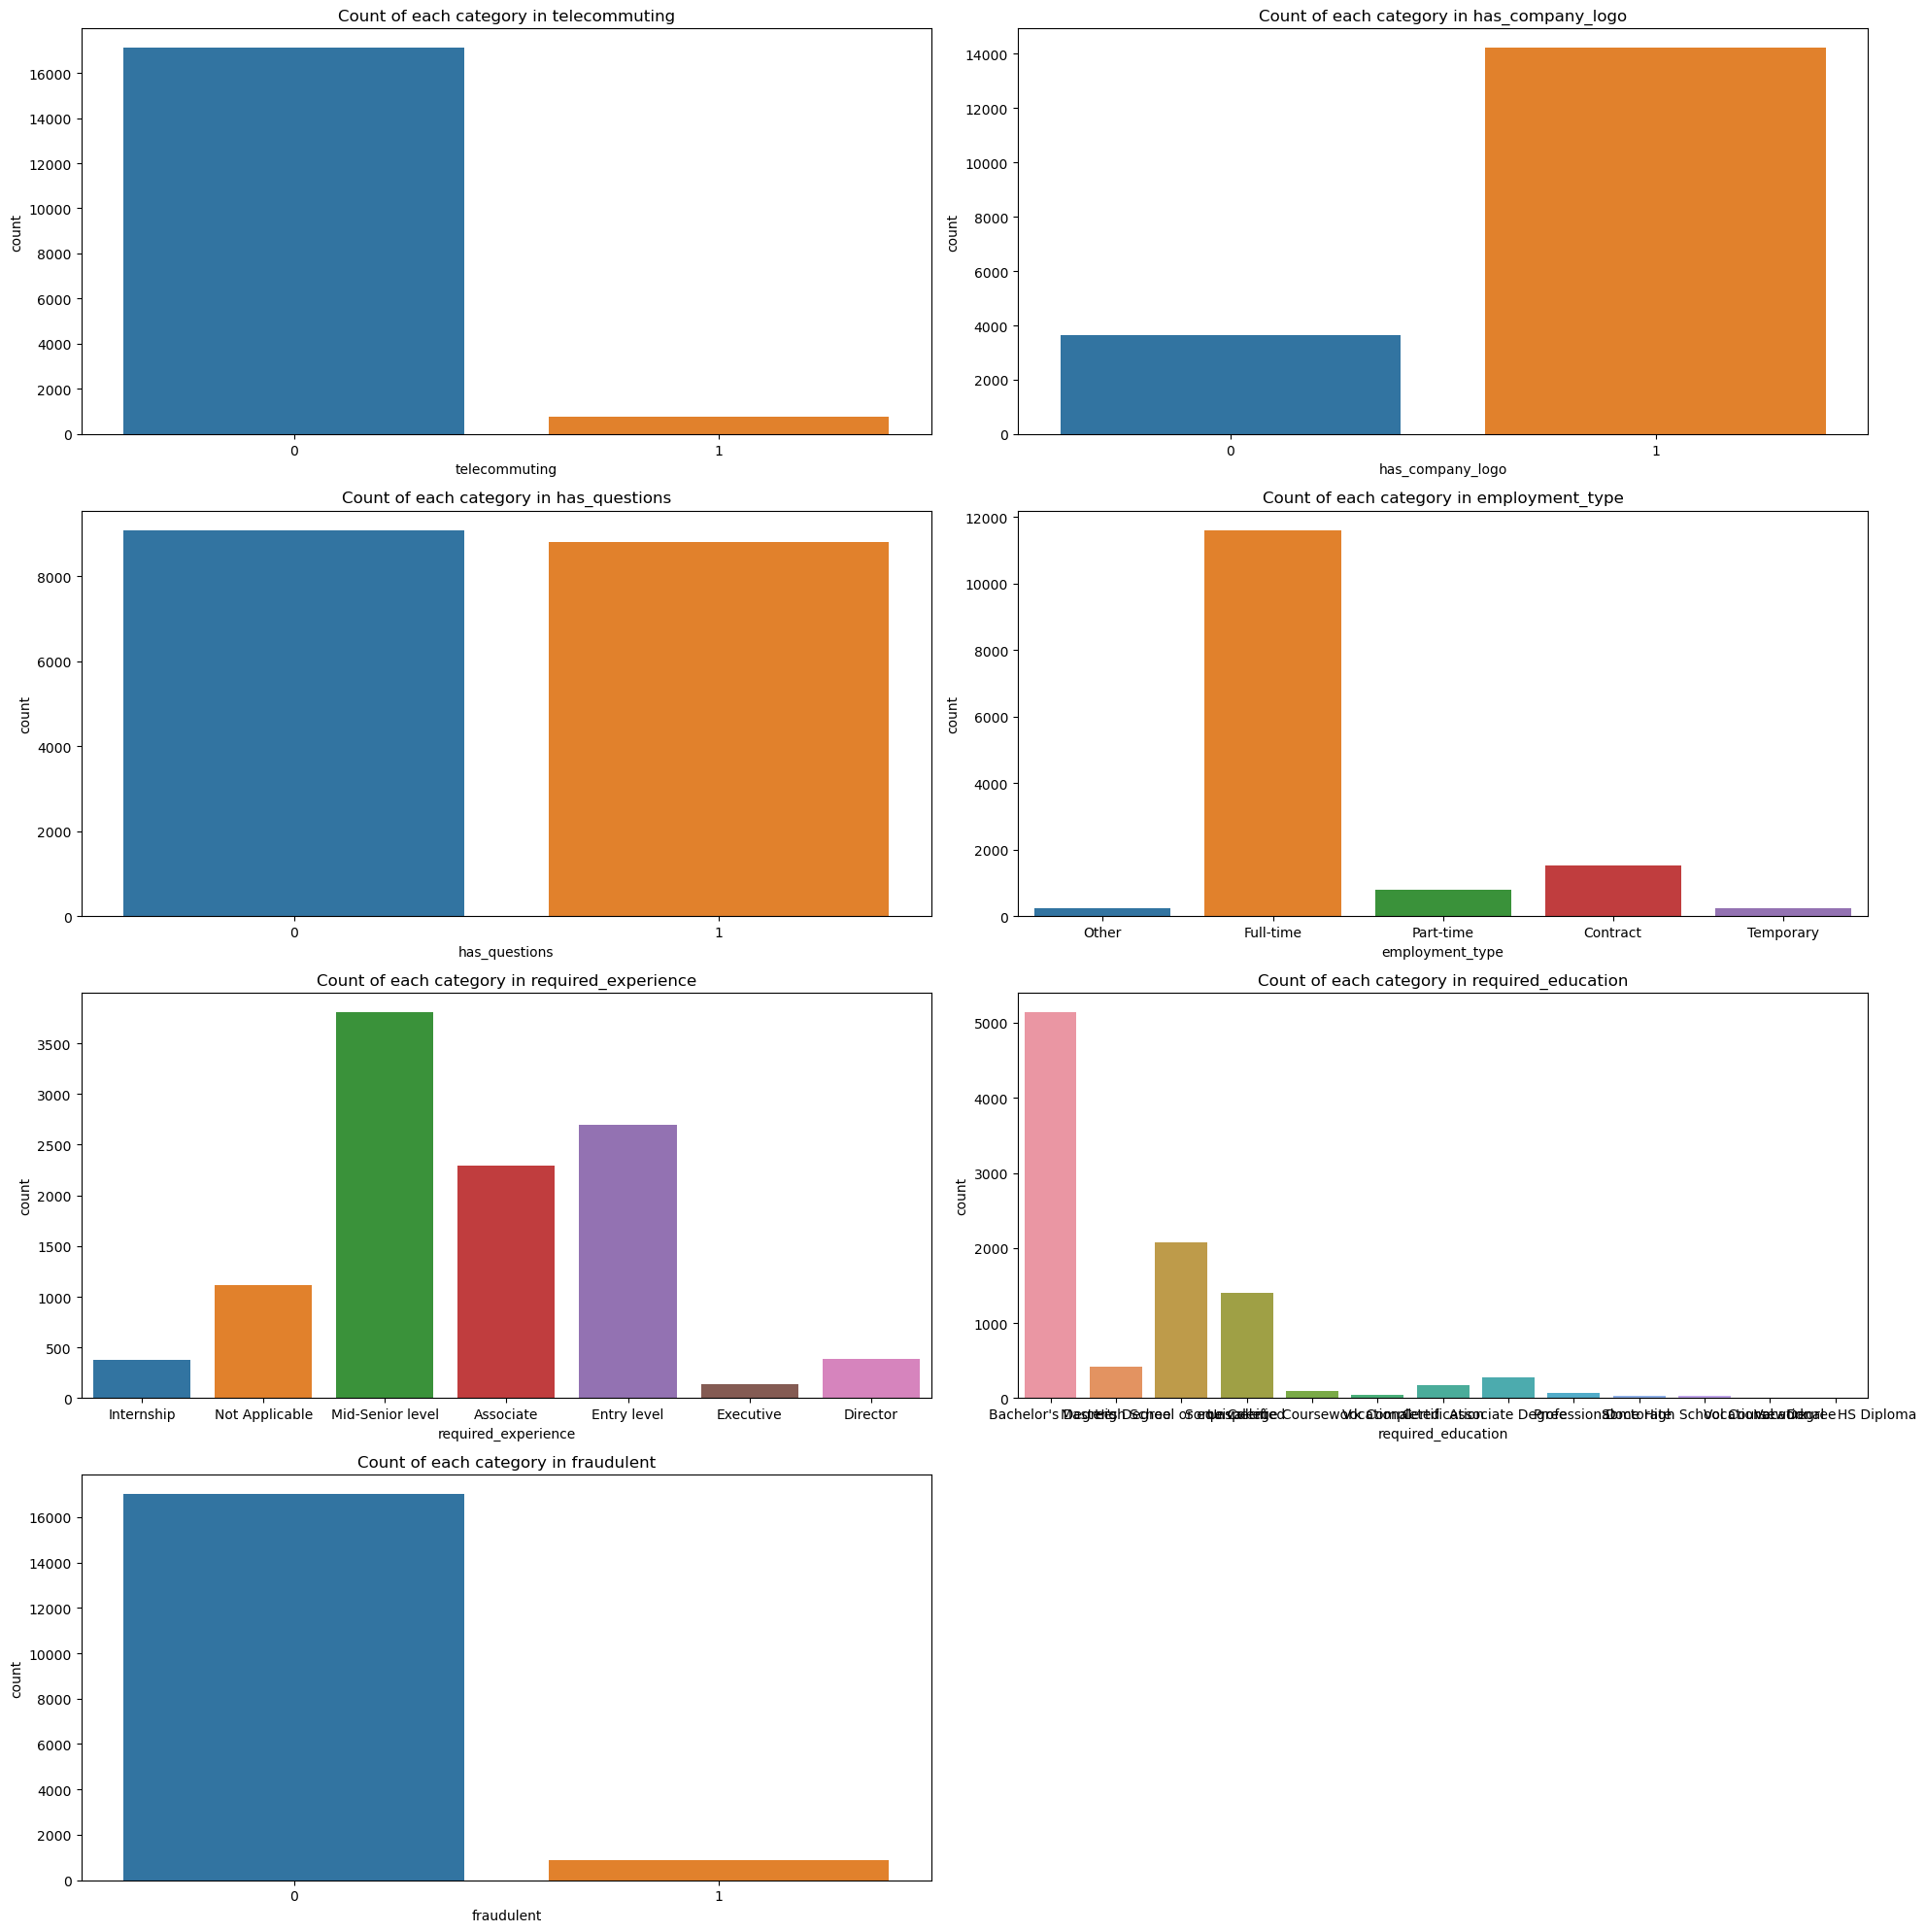

In [136]:
# Distribution of categorial and binary variables:
categorical_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience',
                    'required_education','fraudulent']

n_cols = 2
n_rows = int(np.ceil(len(categorical_cols)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20),sharey=False)
col_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        sns.countplot(ax=axes[row, col], x=categorical_cols[col_idx], data=df_init)
        axes[row, col].set_title(f'Count of each category in {categorical_cols[col_idx]}')
        col_idx += 1
        if col_idx >= len(categorical_cols):
            break

if n_cols*n_rows >  len(categorical_cols):
    for ax in axes.flatten()[len(categorical_cols):]:
        ax.remove()
plt.tight_layout()
plt.show()

In [137]:
#deeper insights on text variables and adding one connected with missing values in text fields:
def missing_text(x):
    if type(x)==float or type(x)==int: 
        if isnan(x):
            return 1
    if type(x)==string:
        if len(x)==0:
            return 1
    return 0

text_cols = ['department','company_profile','description','requirements','benefits','industry','function']

for var in text_cols:
    df_init[var + "_missing"]=df_init[var].apply(missing_text)

#creating summary column:
df_init['missing_sum']=df_init['department_missing']+df_init['company_profile_missing']+df_init['description_missing']+df_init['requirements_missing']+df_init['benefits_missing']+df_init['industry_missing']+df_init['function_missing']

#dropping unnecesary partial columns:
df_init=df_init.drop(['department_missing','company_profile_missing','description_missing','requirements_missing','benefits_missing','industry_missing','function_missing'],axis=1)


Average number of missing values in fraudulent cases: 2.596997690531178
Average number of missing values in non-fraudulent cases: 1.990889855413189
Difference:  0.6061078351179889


<function matplotlib.pyplot.show(close=None, block=None)>

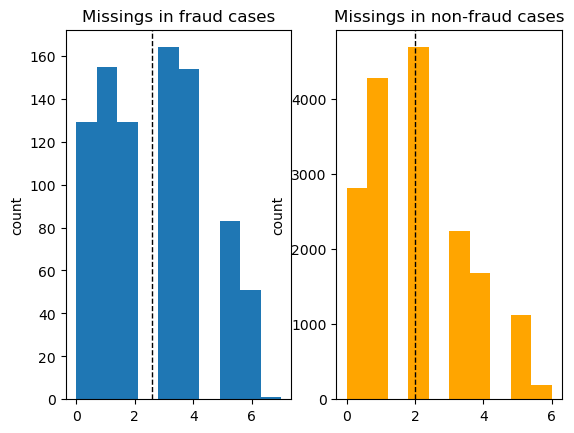

In [138]:
#cheking whether new variable might be useful:
print('Average number of missing values in fraudulent cases:',df_init['missing_sum'][df_init['fraudulent']==1].mean())
print('Average number of missing values in non-fraudulent cases:',df_init['missing_sum'][df_init['fraudulent']==0].mean())
dif=df_init['missing_sum'][df_init['fraudulent']==1].mean()-df_init['missing_sum'][df_init['fraudulent']==0].mean()
print('Difference: ',dif)
df_fraud_missing = df_init['missing_sum'][df_init['fraudulent']==1]
df_nfraud_missing = df_init['missing_sum'][df_init['fraudulent']==0]

plt.subplot(1,2,1)
plt.hist(df_fraud_missing)
plt.title('Missings in fraud cases')
plt.axvline(df_fraud_missing.mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('count')
plt.show
plt.subplot(1,2,2)
plt.title('Missings in non-fraud cases')
plt.axvline(df_nfraud_missing.mean(), color='k', linestyle='dashed', linewidth=1)
plt.hist(df_nfraud_missing, color='orange')
plt.ylabel('count')
plt.show

In [139]:
#looking for some insight on cases marked with "1" in class:
df_init[df_init['fraudulent']==1][:20]

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,missing_sum
job_id,,,,,,,,,,,,,,,,,,
99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,0
145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1,6
174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,0
181,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1,2
216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,0
358,Financing Auto(car) sales,"US, IL, hazelcrest",hr,35000-73000,Looking for adventurous people to join a thriv...,If you have experience in financing for auto s...,prior car sales expprior car loan financing exp,profit sharingcar allowancecompany car,0,0,0,Contract,Associate,NaN,Automotive,NaN,1,1
494,Admin Assistant/ Receptionist,"US, CA, Los Angeles",NaN,23040-28800,NaN,"A Newly established company seeks outgoing, fr...","Must have good knowledge of Outlook, Microsoft...",NaN,0,0,0,Full-time,Entry level,High School or equivalent,Computer Software,Administrative,1,3
538,Technology Consultant - Outside Sales,"US, OH,",NaN,NaN,NaN,Apply below using link#URL_00962c0bdac3ecf40b2...,NaN,NaN,0,0,0,Full-time,NaN,NaN,Information Technology and Services,NaN,1,5
574,Senior Engineering Product Manager,"US, CA, San Jose",Engineering,NaN,Aptitude Staffing Solutions has redesigned the...,Senior Engineering Product ManagerAs a member ...,Skills and Requirements MSEE with 5 years of e...,"What is offered:Broad responsibility, autonomy...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Networking,Engineering,1,0


In [140]:
#Imputing null values:
#location:
df_init['location'] = df_init['location'].fillna(value = df_init['location'].value_counts().index[0])
#Taking department values from job's title
for idx in (df_init[df_init['department'].isna()]['title'].index) : 
    if 'Marketing' in df_init.at[idx ,'title' ] :
        df_init.at[idx , 'department'] = 'Marketing'
    elif 'Sales' in df_init.at[idx ,'title' ] :
        df_init.at[idx , 'department'] = 'Sales'
    elif ('Accountant' in df_init.at[idx ,'title' ])|('Accounting' in df_init.at[idx ,'title' ] ) :
        df_init.at[idx , 'department'] = 'Accounting'
    elif ('Engineer' in df_init.at[idx ,'title' ] )|('Engineering' in df_init.at[idx ,'title' ] ) :
        df_init.at[idx , 'department'] = 'Engineering'
    else :
        df_init.at[idx , 'department'] = df_init.at[idx , 'title']
#Salary (+cleaning nad processing, becasue this will be a continous variable):
df_init['salary_range']=df_init['salary_range'].astype(str)
for idx in (df_init['salary_range'].dropna()).index :
    Range = df_init.at[idx , 'salary_range'].split('-')
    try :
        start = int(Range[0])
        if start < 1000 :
            df_init.at[idx ,'salary_range' ] = 0
        else :
            df_init.at[idx ,'salary_range' ] = start
            
    except ValueError :
        df_init.at[idx ,'salary_range' ] = 0       
df_init['salary_range'] = df_init['salary_range'].fillna(0)
df_init['salary_range'] = df_init['salary_range'].astype(float)

def make_log(x):
    if x==0:
        return 0
    return log(x,2)

df_init['salary_temp'] = df_init['salary_range']/1000
df_init['salary'] = np.vectorize(make_log)(df_init['salary_temp'])
df_init = df_init.drop(['salary_range','salary_temp'],axis=1)


#Other text variables:
df_init[['company_profile' , 'description','requirements','benefits','industry' , 'function']] = df_init[['company_profile' , 'description','requirements','benefits','industry' , 'function']].fillna('no data')
#Other non-text variables:
df_init[['employment_type','required_experience','required_education']] = df_init[['employment_type','required_experience','required_education']].fillna('no data')

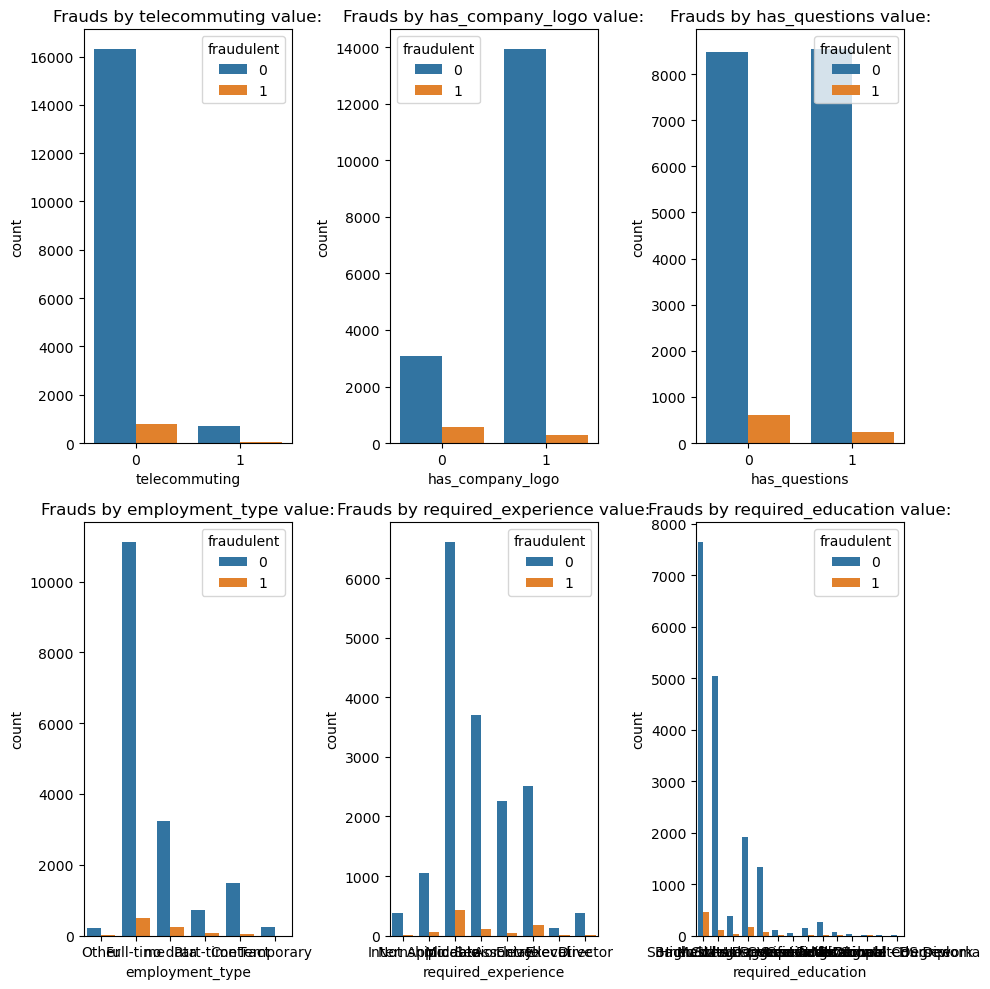

In [141]:
# New check on categorials and binaries:
categorical_cols.pop(-1)
n_cols = 3
n_rows = int(np.ceil(len(categorical_cols)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10),sharey=False)
col_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        sns.countplot(ax=axes[row, col], x=categorical_cols[col_idx], data=df_init, hue='fraudulent')
        axes[row, col].set_title(f'Frauds by {categorical_cols[col_idx]} value:')
        col_idx += 1
        if col_idx >= len(categorical_cols):
            break

if n_cols*n_rows >  len(categorical_cols):
    for ax in axes.flatten()[len(categorical_cols):]:
        ax.remove()
plt.tight_layout()
plt.show()

In [142]:
#checking mean for telecommuting, relation to fraud is not obvious looking on the plot:
print('Average telecommuting value in fraudulent cases:',df_init['telecommuting'][df_init['fraudulent']==1].mean())
print('Average telecommuting value in non-fraudulent cases:',df_init['telecommuting'][df_init['fraudulent']==0].mean())

Average telecommuting value in fraudulent cases: 0.07390300230946882
Average telecommuting value in non-fraudulent cases: 0.041318913835664745


In [143]:
#New Columns for location and text variable:
def imput_value(row,num):
    '''Function created to create new columns from location column'''
    temp = row.split(',')
    if len(temp)>=num+1:
        return temp[num]
    else:
        return('-')
#Location, exception for US:
def return_country(x,y):
    if x=='US':
        return ('US-'+y)
    return x

df_init['country_temp'] = df_init['location'].apply(lambda x: imput_value(x,0))
df_init['state'] = df_init['location'].apply(lambda x: imput_value(x,1))
df_init['city'] = df_init['location'].apply(lambda x: imput_value(x,2))
df_init['country'] = np.vectorize(return_country)(df_init['country_temp'],df_init['state'])


df_init = df_init.drop(['location','country_temp'],axis=1)
#Creating text column:
df_init['text'] = df_init['title'] + ' ' + df_init['department'] + ' ' + df_init['company_profile'] + ' ' + df_init['description'] + ' ' + df_init['requirements'] + ' ' + df_init['industry'] + ' ' + df_init['function'] + ' ' + df_init['benefits'] + ' '
df_init = df_init.drop(['title','department','company_profile','description','requirements','industry','function','benefits'], axis=1)

In [144]:
#Checking unique values again:
for col in df_init.columns:
    print(f"{col}: {df_init[col].nunique()} unique values")
print(df_init['required_experience'].unique())
print(df_init['required_education'].unique())
print(df_init['employment_type'].unique())
print(df_init['country'].unique())

telecommuting: 2 unique values
has_company_logo: 2 unique values
has_questions: 2 unique values
employment_type: 6 unique values
required_experience: 8 unique values
required_education: 14 unique values
fraudulent: 2 unique values
missing_sum: 8 unique values
salary: 15 unique values
state: 326 unique values
city: 2336 unique values
country: 142 unique values
text: 16169 unique values
['Internship' 'Not Applicable' 'no data' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
['no data' "Bachelor's Degree" "Master's Degree"
 'High School or equivalent' 'Unspecified'
 'Some College Coursework Completed' 'Vocational' 'Certification'
 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']
['Other' 'Full-time' 'no data' 'Part-time' 'Contract' 'Temporary']
['US- NY' 'NZ' 'US- IA' 'US- DC' 'US- FL' 'US- MD' 'DE' 'US- CA' 'US- AZ'
 'US- NJ' 'GB' 'US- CT' 'AU' 'SG' 'IL' 'US- PA' 'US- TX' 'AE' 'US- MO'
 'C

Distribution of frauds in:  required_experience
              value  count perc.  fraud perc.
0        Internship     2.130872     2.624672
1    Not Applicable     6.241611     5.376344
2           no data    39.429530     6.170213
3  Mid-Senior level    21.303132     2.966658
4         Associate    12.846756     1.828472
5       Entry level    15.083893     6.637004
6         Executive     0.788591     7.092199
7          Director     2.175615     4.370180
Distribution of frauds in: 

C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter 

 required_education


C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter 

                                value  count perc.  fraud perc.
0                             no data    45.329978     5.564466
1                   Bachelor's Degree    28.775168     1.943635
2                     Master's Degree     2.326622     7.451923
3           High School or equivalent    11.633110     8.173077
4                         Unspecified     7.813199     4.366500
5   Some College Coursework Completed     0.570470     2.941176
6                          Vocational     0.274049     0.000000
7                       Certification     0.950783    11.176471
8                    Associate Degree     1.532438     2.189781
9                        Professional     0.413870     5.405405
10                          Doctorate     0.145414     3.846154
11        Some High School Coursework     0.151007    74.074074
12                Vocational - Degree     0.033557     0.000000
13            Vocational - HS Diploma     0.050336     0.000000
Distribution of frauds in:  employment_t

C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter 

C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter 

C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1])
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\2351435161.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meter 

      value  count perc.  fraud perc.
0    US- NY     7.041387     5.401112
1        NZ     1.862416     0.000000
2    US- IA     0.475391     3.529412
3    US- DC     1.543624     2.536232
4    US- FL     2.321029     7.228916
..      ...          ...          ...
137      NI     0.022371     0.000000
138      LK     0.011186     0.000000
139      JM     0.005593     0.000000
140      KZ     0.005593     0.000000
141      KH     0.005593     0.000000

[142 rows x 3 columns]


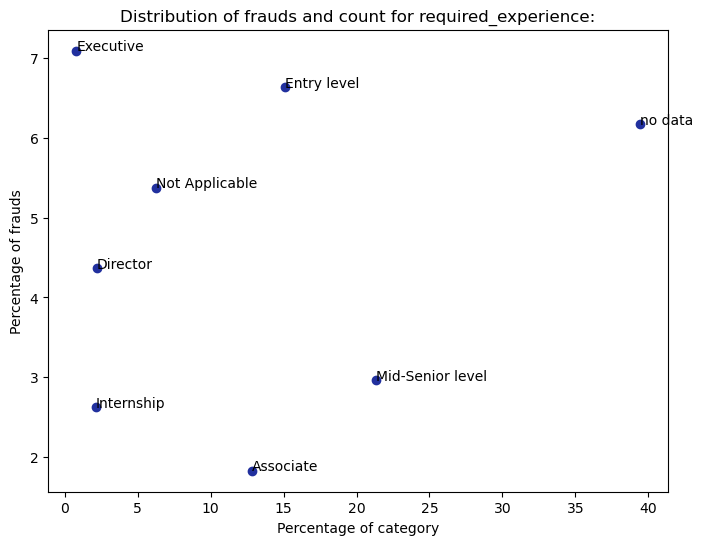

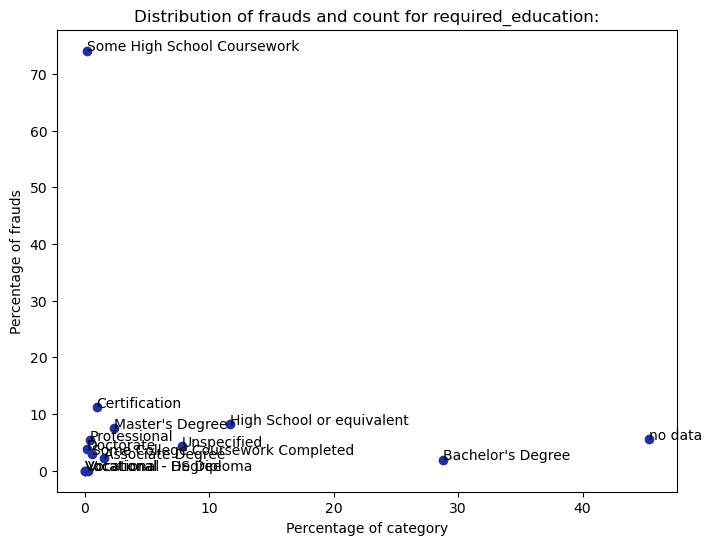

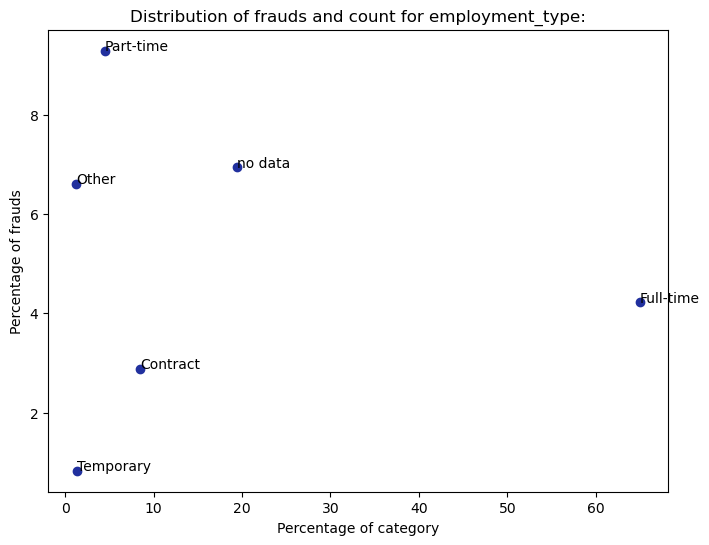

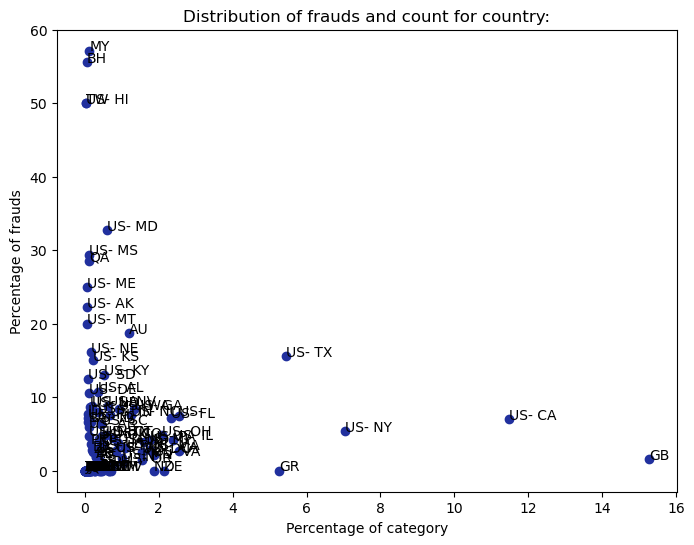

In [145]:
#Plots for possible clustering:
cols_to_cluster = ['required_experience','required_education','employment_type','country']
all = len(df_init)
for col in cols_to_cluster:
    print('Distribution of frauds in: ',col)
    count = []
    perc = []
    names = []
    for unv in df_init[col].unique():
        names.append(unv)
        denominator = len(df_init[df_init[col]==unv]) 
        count.append((denominator/all)*100)
        meter = len(df_init[df_init[col]==unv][df_init['fraudulent']==1]) 
        perc.append((meter/denominator)*100)
    df_temp=pd.DataFrame(list(zip(names, count,perc)),
    columns =['value', 'count perc.','fraud perc.'])
    print(df_temp)
    fig= plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    v = df_temp['value'].values.tolist() 
    x = df_temp['count perc.'].values.tolist()
    y = df_temp['fraud perc.'].values.tolist()
    plt.scatter(x,y,c='#21309e')
    plt.title(f'Distribution of frauds and count for {col}:')
    plt.xlabel('Percentage of category')
    plt.ylabel('Percentage of frauds')
    for i,txt in enumerate(v):
        ax.annotate(txt,(x[i],y[i]))
    plt.show

In [146]:
#checking for values to split countries for regions: 
gr_cond=[0,5,10,18,35]
print('COUNTRIES:')
print('share of zero: ', (df_temp[df_temp['fraud perc.']==gr_cond[0]]['count perc.'].sum()))
print('share of low: ', (df_temp[df_temp['fraud perc.']>gr_cond[0]][df_temp['fraud perc.']<=gr_cond[1]]['count perc.'].sum()))
print('share of low-mid: ', (df_temp[df_temp['fraud perc.']>gr_cond[1]][df_temp['fraud perc.']<=gr_cond[2]]['count perc.'].sum()))
print('share of mid: ', (df_temp[df_temp['fraud perc.']>gr_cond[2]][df_temp['fraud perc.']<=gr_cond[3]]['count perc.'].sum()))
print('share of high-mid: ', (df_temp[df_temp['fraud perc.']>gr_cond[3]][df_temp['fraud perc.']<=gr_cond[4]]['count perc.'].sum()))
print('share of high: ', (df_temp[df_temp['fraud perc.']>gr_cond[4]]['count perc.'].sum()))

zero=df_temp[df_temp['fraud perc.']==gr_cond[0]]['value'].tolist()
low=df_temp[df_temp['fraud perc.']>gr_cond[0]][df_temp['fraud perc.']<=gr_cond[1]]['value'].tolist()
low_mid=df_temp[df_temp['fraud perc.']>gr_cond[1]][df_temp['fraud perc.']<=gr_cond[2]]['value'].tolist()
mid=df_temp[df_temp['fraud perc.']>gr_cond[2]][df_temp['fraud perc.']<=gr_cond[3]]['value'].tolist()
high_mid=df_temp[df_temp['fraud perc.']>gr_cond[3]][df_temp['fraud perc.']<=gr_cond[4]]['value'].tolist()
high=df_temp[df_temp['fraud perc.']>gr_cond[4]]['value'].tolist()

COUNTRIES:
share of zero:  16.582774049217
share of low:  44.31208053691275
share of low-mid:  29.80984340044743
share of mid:  6.923937360178971
share of high-mid:  2.158836689038031
share of high:  0.21252796420581657


C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\1180347471.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('share of low: ', (df_temp[df_temp['fraud perc.']>gr_cond[0]][df_temp['fraud perc.']<=gr_cond[1]]['count perc.'].sum()))
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\1180347471.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('share of low-mid: ', (df_temp[df_temp['fraud perc.']>gr_cond[1]][df_temp['fraud perc.']<=gr_cond[2]]['count perc.'].sum()))
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\1180347471.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('share of mid: ', (df_temp[df_temp['fraud perc.']>gr_cond[2]][df_temp['fraud perc.']<=gr_cond[3]]['count perc.'].sum()))
C:\Users\kadab\AppData\Local\Temp\ipykernel_21624\1180347471.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('share of high-mid: ', (df_te

In [147]:
#Dropping detailed location variables (there are to many unique values, it will be confusing for ma model) for risk groups:
df_init = df_init.drop(['state','city'],axis=1)
#Grouping country values by defined risk group:
regions = {'Zero Risk': zero,
             'Low Risk' : low,
             'Low-Mid Risk': low_mid,
              'Mid Risk' : mid,
             'High-Mid Risk' : high_mid,
             'High Risk' : high}

def regionalize(x):
    global regions
    for reg in regions:
        if x in regions[reg]:
            return reg
    return 'Other'

df_init['region'] = df_init['country'].apply(regionalize)
df_init = df_init.drop('country',axis=1)
   
#adding "other" and "no data" and "temporary" and "contract" in employment type
def emp_type_cat(x):
    if x=="Other" or x=="no data":
        return "Other"
    if x=="Temporary" or x=="Contract":
        return "Temporary"
    return x

df_init['employment_group']=df_init['employment_type'].apply(emp_type_cat)
df_init = df_init.drop('employment_type',axis=1)

#Dropping detailed required education variables for risk groups:
edu_risk = {'Low Risk': [ 'Vocational - Degree','Vocational - HS Diploma','Associate Degree','Vocational','Some College Coursework Completed',"Bachelor's Degree"],
           'Mid Risk' : ['no data',"Master's Degree",' Unspecified','Professional','Doctorate'],
            'High Risk' : ['High School or equivalent','Certification'],
            'Super Risk' : ['Some High School Coursework']}

def education_risk(x):
    global edu_risk
    for risk in edu_risk:
        if x in edu_risk[risk]:
            return risk
    return 'Other'

df_init['education']=df_init['required_education'].apply(education_risk)
df_init = df_init.drop('required_education',axis=1)

#Encoding variables:
def onehot(x, var):
    '''Function for one hot encoding'''
    if x==var:
        return 1
    else:
        return 0

columns_to_1hot = ['employment_group','required_experience','education','region']

for column in columns_to_1hot:
    for val in df_init[column].unique():
        df_init[column+ "_"+ val] = df_init[column].apply(lambda x: onehot(x,val))

df_init = df_init.drop(columns_to_1hot,axis=1)
df_init

,telecommuting,has_company_logo,has_questions,fraudulent,missing_sum,salary,text,employment_group_Other,employment_group_Full-time,employment_group_Part-time,employment_group_Temporary,required_experience_Internship,required_experience_Not Applicable,required_experience_no data,required_experience_Mid-Senior level,required_experience_Associate,required_experience_Entry level,required_experience_Executive,required_experience_Director,education_Mid Risk,education_Low Risk,education_High Risk,education_Other,education_Super Risk,region_Low-Mid Risk,region_Zero Risk,region_Low Risk,region_High-Mid Risk,region_Mid Risk,region_High Risk
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,2,0,"Marketing Intern Marketing We're Food52, and w...",1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,Customer Service - Cloud Video Production Succ...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,4,0,Commissioning Machinery Assistant (CMA) Commis...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,Account Executive - Washington DC Sales Our pa...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,0,1,1,0,1,0,Bill Review Manager Bill Review Manager SpotSo...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,0,1,1,0,0,0,Account Director - Distribution Sales Vend is...,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
17877,0,1,1,0,0,0,Payroll Accountant Accounting WebLinc is the e...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
17878,0,0,0,0,4,0,Project Cost Control Staff Engineer - Cost Con...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [151]:
df_init['salary'].unique()

array([ 0,  4,  6,  5,  3,  8,  7,  9,  2,  1, 19, 11, 12, 10, 18])

In [149]:
#Changing the name of target variable (might be confusing after word-scoring by NLP methods):
df_init['#fraudulent']=df_init['fraudulent']
df_init = df_init.drop('fraudulent',axis=1)

In [150]:
#Splitting and saving csvs:
nlp_teacher, nlp_student = train_test_split(df_init, test_size=0.5)
print('Distribution of target value in set for nlp model to learn: ',list(Counter(nlp_teacher['#fraudulent']).items()))
print('Distribution of target value in set to include variables gained with nlp: ',list(Counter(nlp_student['#fraudulent']).items()))
nlp_teacher.to_csv('df_nlp_teacher.csv', sep=";", encoding='utf-8')
nlp_student.to_csv('df_nlp_student.csv', sep=";", encoding='utf-8')

Distribution of target value in set for nlp model to learn:  [(0, 8492), (1, 448)]
Distribution of target value in set to include variables gained with nlp:  [(0, 8522), (1, 418)]
